I always import pandas and nump as my defaults. For this assignment, I noticed the emphasis on timing in the assingment prompt, so I brought in the time library as well.

In [63]:
# Basics
import pandas as pd
import numpy as np
import time

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data Prep
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# Methods
from sklearn.svm import SVC # SVM
from sklearn.naive_bayes import MultinomialNB # NB
from sklearn.linear_model import LogisticRegression # LR

# CNN
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Import the data
from datasets import load_dataset
data = load_dataset("stanfordnlp/imdb")

I checked to see what kind of data I was working with to see if I needed to get it into a pandas dataframe or if that was the default.

In [49]:
print("Data type:")
display(type(data))
display(data)
train_data = pd.DataFrame(data['train'])
test_data = pd.DataFrame(data['test'])

# pd.set_option('display.max_colwidth', 50)
print("Training Data:")
display(train_data.head(5))

print("Testing Data:")
display(test_data.head(5))

Data type:


datasets.dataset_dict.DatasetDict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Training Data:


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


Testing Data:


,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


I'm in a unique situation here, where the distribution of data is already given to me. That said, I like to double check my data just to be sure there are no surprises, so I checked the distribution of positive/negative labels, just to confirm.

In [50]:
display(train_data['label'].value_counts())

label
0    12500
1    12500
Name: count, dtype: int64

The instructions and intro document was correct, the data is distributed evenly. If the data was uneven, I would consider using the SMOTE algorithm to balance out the data.

I also want to check null values and make sure nothing is missing or any rows need to be dropped.

In [51]:
print(train_data.isnull().sum())

text     0
label    0
dtype: int64


No nulls is good nulls.

For my own EDA andanalysis down the road, I'd like to see the data, specifically the length of the data and the most used words in the reviews. Later, when classifying, we can start making connections and seeing if reviews under 500 characters are more likely to be negative or positive, can some high-use words be used to predict a positive or negative review like you would do for a spam email containing "free" or "$$$", etc.

In [52]:
# Get lengths of each review for a histogram
train_data['length'] = train_data['text'].apply(len)
print(train_data['length'].describe())

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: length, dtype: float64


C:\Users\mroberts\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


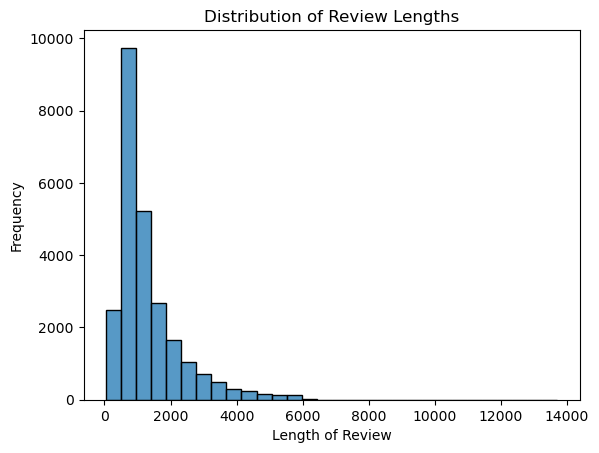

In [53]:
# Plot histogram
sns.histplot(train_data['length'], bins=30)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

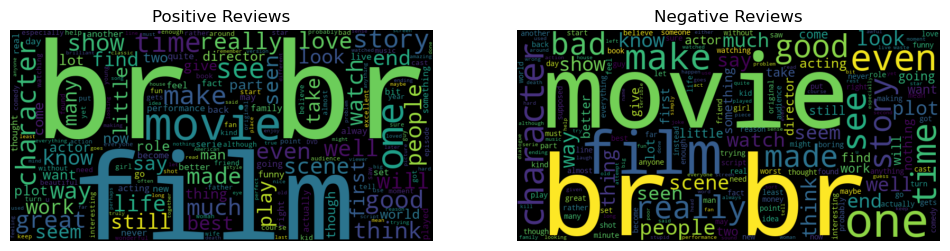

In [54]:
# Word Clouds

# Split reviews
positive_reviews = ' '.join(train_data[train_data['label'] == 1]['text'])
negative_reviews = ' '.join(train_data[train_data['label'] == 0]['text'])

# Create the clouds
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_reviews)

# Plot both
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()

I did the wordcloud because i like them, not necessarily because they were useful here. I wanted to see the high frequency words and I could have done that in a sorted list. I was glad I did them because it brought this "br" to my attention. My initial reaction was that they were most likely a newline break tag.

In [55]:
# Remove truncation to see the whole entry, only one needed here for space
pd.set_option('display.max_colwidth', None) # https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver
display(train_data.head(1))

,text,label,length
0,"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films.<br /><br />I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot.",0,1640


I was correct, so I removed them from training and testing data since they are not part of the reviews.

In [56]:
train_data['text'] = train_data['text'].apply(lambda x: x.replace("<br />"," "))
test_data['text'] = test_data['text'].apply(lambda x: x.replace("<br />"," "))
display(train_data.head(1))
pd.set_option('display.max_colwidth', 50)

'Training Data: '

,text,label,length
0,"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself. The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films. I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot.",0,1640


Once I confirmed the \<br /> tags were removed, I reran the wordcloud.

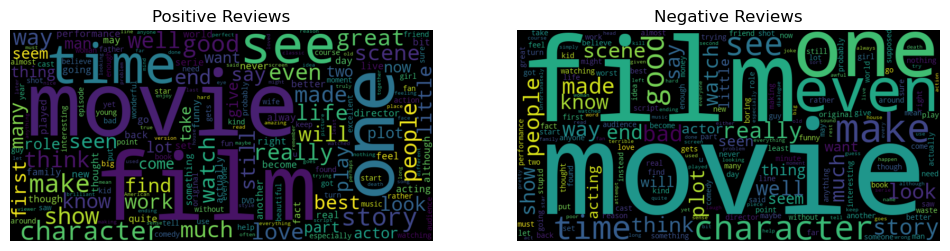

In [57]:
positive_reviews = ' '.join(train_data[train_data['label'] == 1]['text'])
negative_reviews = ' '.join(train_data[train_data['label'] == 0]['text'])

wordcloud_positive = WordCloud(width=800, height=400).generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()

Now that it looked good with no strange words in the clouds, I was able to get started. I set up my 'text' columns as TF-IDF vectors and set up my training and testing data to be used throughout the different models. I also removed the regular stopwords to help with my storage size. TD-IDF ranks those words lower anyway so I don't need them.

In [58]:
vectorized = TfidfVectorizer(stop_words = 'english')

# training data
X_train = vectorized.fit_transform(train_data['text'])
y_train = train_data['label']

# testing data
X_test = vectorized.transform(test_data['text'])
y_test = test_data['label']

grid search svm parameters

In [8]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy') # https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

# Fit it to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and estimator
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_

svm_start_pred = time.time()
svm_y_pred = best_svm.predict(X_test)
svm_end_pred = time.time()
svm_pred_time = round((svm_end_pred - svm_start_pred) / 60, 2)
print("Time to predict with best SVM: ", svm_pred_time, " minutes.")

print(f'Accuracy: {accuracy_score(y_test, svm_y_pred)}')
print(classification_report(y_test, svm_y_pred))

Best parameters: {'C': 1, 'kernel': 'rbf'}
Best estimator: SVC(C=1)
Time to predict with best SVM:  9.99  minutes.
Accuracy: 0.8866
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     12500
           1       0.89      0.88      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [13]:
svm_start_train = time.time()
svm = SVC(kernel = 'linear') # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
svm.fit(X_train, y_train)
svm_end_train = time.time()
svm_fit_time = round((svm_end_train - svm_start_train) / 60,2)
print("Time to train SVM: ", svm_fit_time, " minutes.")

svm_start_pred = time.time()
svm_y_pred = svm.predict(X_test)
svm_end_pred = time.tim()
svm_pred_time = round((svm_end_pred - svm_start_pred) / 60,2)
print("Time to predict SVM: ", svm_pred_time, " minutes.")

print(f'Accuracy: {accuracy_score(y_test, svm_y_pred)}')
print(classification_report(y_test, svm_y_pred))

Time to train SVM:  14.95  minutes.


do it for NB using the same organization

In [60]:
nb_start_train = time.time()
nb = MultinomialNB() # https://scikit-learn.org/0.24/modules/generated/sklearn.naive_bayes.MultinomialNB.html
nb.fit(X_train, y_train)
nb_end_train = time.time()
nb_fit_time = round((nb_end_train - nb_start_train) / 60,2)
print("Time to predict NB: ", nb_fit_time, " minutes.")

nb_start_test = time.time()
nb_y_pred = nb.predict(X_test)
nb_end_test = time.time()
nb_pred_time = round((nb_end_test - nb_start_test) / 60,2)
print("Time to fit NB: ", nb_pred_time, " minutes.")

print(f'Accuracy: {accuracy_score(y_test, nb_y_pred)}')
print(classification_report(y_test, nb_y_pred))

Time to predict NB:  0.0  minutes.
Time to fit NB:  0.0  minutes.
Accuracy: 0.82964
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     12500
           1       0.86      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [75]:
lr_start_train = time.time()
lr = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0) # https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
lr.fit(X_train, y_train)
lr_end_train = time.time()
lr_fit_time = round((lr_end_train - lr_start_train) / 60,2)
print("Time to predict NB: ", lr_fit_time, " minutes.")

lr_start_test = time.time()
lr_y_pred = lr.predict(X_test)
lr_end_test = time.time()
lr_pred_time = round((lr_end_test - lr_start_test) / 60,2)
print("Time to fit NB: ", lr_pred_time, " minutes.")

print(f'Accuracy: {accuracy_score(y_test, lr_y_pred)}')
print(classification_report(y_test, lr_y_pred))

Time to predict NB:  0.02  minutes.
Time to fit NB:  0.0  minutes.
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



possible CNN code

In [ ]:
import keras_tuner as kt

# Encode labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])

# Tokenize the text data
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['text'])

X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the CNN model
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=hp.Int('input_dim', 10000, 20000, step=5000), 
                        output_dim=hp.Choice('output_dim', [128, 256, 512]), 
                        input_length=max_len))
    model.add(Conv1D(filters=hp.Choice('filters', [64, 128, 256]), 
                     kernel_size=hp.Choice('kernel_size', [3, 5, 7]), 
                     activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', [2, 3])))
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='tuning_dir',
    project_name='cnn_tuning'
)

tuner.search(X_train_pad, y_train, epochs=5, validation_split=0.2)

# Retrieve the best model after search
best_model = tuner.get_best_models(num_models=1)[0]

# Display a summary of the best model
best_model.summary()

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test_pad, y_test)
print(f'Best model test accuracy: {round(accuracy, 2)}')


# # Train the model
# model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test_pad, y_test)
# print(f'Test accuracy: {round(accuracy,2)}')


Trial 3 Complete [00h 12m 59s]
val_accuracy: 0.8078999817371368

Best val_accuracy So Far: 0.8136000037193298
Total elapsed time: 00h 25m 49s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
15000             |20000             |input_dim
256               |128               |output_dim
256               |64                |filters
7                 |5                 |kernel_size
relu              |tanh              |activation
3                 |2                 |pool_size
0.3               |0.3               |dropout_rate
adam              |adam              |optimizer

Epoch 1/5
 62/625 ━━━━━━━━━━━━━━━━━━━━ 1:02 111ms/step - accuracy: 0.5879 - loss: 0.6722

first was relu activations in the Conv1D, 88% accuracy. Sigmoid gave 82%, tanh gave 83%